# About

A sketch of the [machine translation tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) from the [PyTorch Tutorials](https://pytorch.org/tutorials/index.html).

It's the closest analogy to automated document conversion, so this is an attempt to study its internals.

## Model

This is a sequence-to-sequence (seq2seq) model, consisting of a pair of [recurrent neural networks (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network), the encoder and decoder. 

The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

![diagram](images/seq2seq.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Encoder

This is the first half of the RNN seq2seq network, aka [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf).

For every input (word token, in this example) the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![encoder](images/encoder-network.png)

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # using a multi-layer gated recurrent unit (GRU) 
        # as an improvement over long short-term memory (LSTM) 
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input_layer, hidden_layer):
        embedded = self.embedding(input_layer).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden_layer)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decoder

The is the second half of the model, another RNN that takes the encoder's output vectors as its input, and outputs a sequence of words to create the translation:

![decoder](images/decoder-network.png)

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_layer, hidden_layer):
        output = self.embedding(input_layer).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden_layer)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Decoder

Without this, the context vector which is passed betweeen the encoder and decoder carries the burden of encoding the entire sentence.

The attention RNN allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs.

![diagram](images/attention-decoder.png)

Calculating the attention weights is done with another feed-forward layer, `attn`, using the decoder's input and hidden state as inputs.

Rather than using [bucketing](https://www.kaggle.com/bminixhofer/speed-up-your-rnn-with-sequence-bucketing) for handling inputs of variable length in the training data, this example chooses a maximum sentence length that gets applied to all inputs: sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

![diagram](images/attention-decoder-network.png)

In [6]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout, max_length):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input_layer, hidden_layer, encoder_outputs):
        embedded = self.embedding(input_layer).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden_layer[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden_layer)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training Functions

In [7]:
# helper functions

import time
import math

def in_minutes(seconds):
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

def since(prior, percent):
    seconds = time.time() - prior
    gap = (seconds / percent) - seconds
    return '%s (- %s)' % (in_minutes(seconds), in_minutes(gap))

In [8]:
import random

teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, enc_optimizer, dec_optimizer, crit, max_len):
    encoder_hidden = encoder.init_hidden()

    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_len, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += crit(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += crit(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    enc_optimizer.step()
    dec_optimizer.step()

    return loss.item() / target_length

In [9]:
# for plotting results
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

def show_plot(data):
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(data)

In [10]:
from torch import optim

def train_tensors(encoder, decoder, training_tensors, max_len, print_every, plot_every, learning_rate):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    iterations = len(training_tensors)
    for i in range(1, iterations+1):
        training_pair = training_tensors[i - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_len)
        print_loss_total += loss
        plot_loss_total += loss

        if i % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (since(start, i / iterations),
                                         i, i / iterations * 100, print_loss_avg))

        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

## Putting it all together

Using the tab-delimited examples from [Anki](https://www.manythings.org/anki/) to see if it's possible to produce a simple English to Spanish translation service.

In [11]:
!if [ ! -f ./data/spa-eng.zip ]; then wget -P ./data https://www.manythings.org/anki/spa-eng.zip; fi

--2020-11-24 18:27:53--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.108.196, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4845402 (4.6M) [application/zip]
Saving to: ‘./data/spa-eng.zip’

spa-eng.zip         100%[===================>]   4.62M  12.4MB/s    in 0.4s    

2020-11-24 18:27:54 (12.4 MB/s) - ‘./data/spa-eng.zip’ saved [4845402/4845402]



In [12]:
!if [ ! -f ./data/spa.txt ]; then unzip -n -d ./data ./data/spa-eng.zip; fi

Archive:  ./data/spa-eng.zip
  inflating: ./data/_about.txt       
  inflating: ./data/spa.txt          


In [13]:
from pathlib import Path
data_file = Path.cwd() / "data/spa.txt"

In [14]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name, parser):
        self.name = name
        self.parser = parser
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2
        
    def add_sentence(self, sentence):
        for word in self.parser(sentence):
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def indices_from_sentence(self, sentence):
        return [self.word2index[word] for word in self.parser(sentence)]

In [15]:
# text normalization to ascii

import unicodedata
import re

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [16]:
"""
Define the language parsers;
both can be more complicated than this, 
but this suffices for this simple model
"""

def parse_spanish(sentence):
    return sentence.split(' ')

def parse_english(sentence):
    return sentence.split(' ')

In [17]:
def parse_language_pairs(input_file=data_file):
    pairs = [] # list of (eng, spa) pairs
    for line in data_file.read_text(encoding='utf-8').splitlines():
        parts = list(map(lambda x: normalize(x.strip()), line.split('\t')))
        if len(parts) > 1:
            pairs.append((parts[0], parts[1]))
    return pairs

In [18]:
MAX_WORD_LENGTH = 12

def filter_by_word_length(pair):
    """
    Since the AttentionDecoderRNN is based on a max_length,
    this function provides a filter based on that parameter 
    """
    return len(pair) == 2 \
      and len(parse_english(pair[0])) < MAX_WORD_LENGTH \
      and len(parse_spanish(pair[1])) < MAX_WORD_LENGTH

In [19]:
samples = [pair for pair in parse_language_pairs() if filter_by_word_length(pair)]

In [20]:
def prepare_sample(parsed_pairs):
    """
    Given a list of (eng, spa) pairs, produce 
    a tuple (Lang(eng), Lang(spa)) of the data
    """
    eng = Lang('eng', parse_english)
    spa = Lang('spa', parse_spanish)
    for pair in parsed_pairs:
        eng.add_sentence(pair[0])
        spa.add_sentence(pair[1])
    return eng, spa

In [21]:
eng, spa = prepare_sample(samples)
len(samples), eng.n_words, spa.n_words

(112833, 11929, 23009)

## Converting training data to [tensors](https://pytorch.org/docs/stable/tensors.html)

In [22]:
def generate_tensor(lang, sentence):
    indicies = lang.indices_from_sentence(sentence)
    indicies.append(EOS_token)
    return torch.tensor(indicies, dtype=torch.long, device=device).view(-1, 1)

In [23]:
training_tensors = [
    (generate_tensor(eng, pair[0]), 
     generate_tensor(spa, pair[1])) 
    for pair in samples
]    

## Train the model

In [24]:
import pickle

encoder_file = Path.cwd() / "data/encoder.pkl"
decoder_file = Path.cwd() / "data/decoder.pkl"

0m 31s (- 29m 19s) (2000 1%) 4.2086
1m 6s (- 30m 1s) (4000 3%) 3.8302
1m 43s (- 30m 43s) (6000 5%) 3.7379
2m 21s (- 30m 58s) (8000 7%) 3.6397
3m 0s (- 30m 55s) (10000 8%) 3.5645
3m 40s (- 30m 52s) (12000 10%) 3.6031
4m 21s (- 30m 43s) (14000 12%) 3.4170
5m 1s (- 30m 27s) (16000 14%) 3.4058
5m 43s (- 30m 12s) (18000 15%) 3.3889
6m 27s (- 29m 56s) (20000 17%) 3.2819
7m 10s (- 29m 36s) (22000 19%) 3.4785
7m 53s (- 29m 13s) (24000 21%) 3.2604
8m 38s (- 28m 50s) (26000 23%) 3.4039
9m 22s (- 28m 24s) (28000 24%) 3.2720
10m 7s (- 27m 58s) (30000 26%) 3.2301
10m 53s (- 27m 29s) (32000 28%) 3.3165
11m 40s (- 27m 3s) (34000 30%) 3.2433
12m 27s (- 26m 35s) (36000 31%) 3.3854
13m 14s (- 26m 5s) (38000 33%) 3.1719
14m 2s (- 25m 33s) (40000 35%) 3.3019
14m 50s (- 25m 1s) (42000 37%) 3.1058
15m 38s (- 24m 28s) (44000 38%) 3.2945
16m 26s (- 23m 53s) (46000 40%) 3.1245
17m 16s (- 23m 20s) (48000 42%) 3.2351
18m 6s (- 22m 44s) (50000 44%) 3.1949
18m 58s (- 22m 11s) (52000 46%) 3.1759
19m 49s (- 21m 35s)

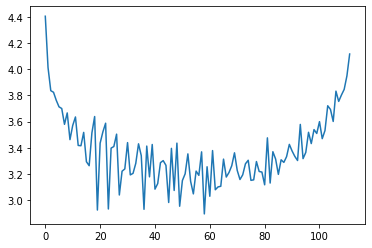

In [25]:
hidden_size = 256

if encoder_file.exists() and decoder_file.exists():
    encoder = pickle.load(open(encoder_file, 'rb'))
    attn_decoder = pickle.load(open(decoder_file, 'rb'))
else:
    encoder = EncoderRNN(eng.n_words, hidden_size).to(device)
    attn_decoder = AttentionDecoderRNN(hidden_size, spa.n_words, 0.1, MAX_WORD_LENGTH).to(device)
    train_tensors(encoder, attn_decoder, training_tensors, MAX_WORD_LENGTH, 2000, 1000, 0.01)
    pickle.dump(encoder, open(encoder_file, 'wb'))
    pickle.dump(attn_decoder, open(decoder_file, 'wb'))

## Evaluate the results

In [26]:
def evaluate(encoder, decoder, input_tensor, output_lang, max_length=MAX_WORD_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        for i in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
            encoder_outputs[i] += encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for i in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[i] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
            
        return decoded_words, decoder_attentions[:i + 1]

In [29]:
def evaluate_pair(encoder, decoder, pair, input_lang, output_lang):
    print('>', pair[0])
    print('=', pair[1])
    output_words, attentions = evaluate(encoder, decoder,  generate_tensor(input_lang, pair[0]), output_lang)
    output_sentence = u' '.join(output_words)
    print('<', output_sentence)
    print('')

In [30]:
# sample some random entries

for i in range(30):
    pair = random.choice(samples)
    evaluate_pair(encoder, attn_decoder, pair, eng, spa)

> i work for an oil company .
= trabajo para una compania petrolera .
< compania a compania compania compania compania compania a compania . <EOS>

> was i really boring ?
=  era tan pesado ?
<  realmente estaba estaba de de de ? ? ? ? ?

> can it be repaired ?
=  se puede reparar ?
< puede puede ser puede ser puede ser ? <EOS>

> we could not swallow his story .
= no nos pudimos tragar su historia .
< no nos historia historia su historia historia su historia historia . <EOS>

> can t we fire tom ?
=  podemos despedir a tom ?
<  podemos podemos no podemos tom tom tom tom ? ? <EOS>

> tom has done what we expected him to do .
= tom ha hecho lo que esperabamos que hiciera .
< tom nos lo que lo que lo que hacer hacer . <EOS>

> he gave his life for his country .
= el dio la vida por su pais .
< su vida su su vida su vida su su vida . <EOS>

> she is a famous singer .
= es una cantante famosa .
< ella es una famoso famoso famoso famoso famoso . <EOS>

> i don t want to go .
= no quiero ir 